<a href="https://colab.research.google.com/github/rahiakela/coursera-deep-learning-specialization/blob/course-2-improving-deep-neural-networks/week_1_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization

Welcome to the first assignment of the hyper parameters tuning specialization. It is very important that you regularize your model properly because it could dramatically improve your results.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-specialization/regularization.png?raw=1' width='800'/>


By completing this assignment you will:

- Understand that different regularization methods that could help your model.

- Implement dropout and see it work on data.

- Recognize that a model without regularization gives you a better accuracy on the training set but nor necessarily on the test set.

- Understand that you could use both dropout and regularization on your model.

This assignment prepares you well for the upcoming assignment. Take your time to complete it and make sure you get the expected outputs when working through the different exercises.

This is the first assignment of this week. Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!

**You will learn to:** Use regularization in your deep learning models.

Let's first import the packages you are going to use.



## Setup

In [0]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
# ovverding this method for Python3.6
# ref: https://stackoverflow.com/questions/46746839/matplotlib-scatter-not-working-with-numpy-on-python-3-6/49567462
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

**Problem Statement**: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-specialization/field_kiank.png?raw=1' width='800'/>
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>


They give you the following 2D dataset from France's past 10 games.

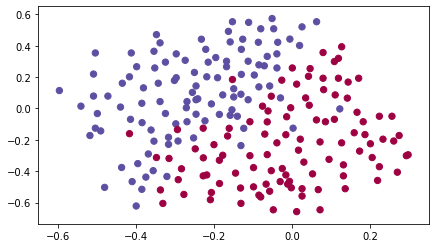

In [7]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well. 

You will first try a non-regularized model. Then you'll learn how to regularize it and decide which model you will choose to solve the French Football Corporation's problem. 

## 1 - Non-regularized model

You will use the following neural network (already implemented for you below). This model can be used:
- in *regularization mode* -- by setting the `lambd` input to a non-zero value. We use "`lambd`" instead of "`lambda`" because "`lambda`" is a reserved keyword in Python. 
- in *dropout mode* -- by setting the `keep_prob` to a value less than one

You will first try the model without any regularization. Then, you will implement:
- *L2 regularization* -- functions: "`compute_cost_with_regularization()`" and "`backward_propagation_with_regularization()`"
- *Dropout* -- functions: "`forward_propagation_with_dropout()`" and "`backward_propagation_with_dropout()`"

In each part, you will run this model with the correct inputs so that it calls the functions you've implemented. Take a look at the code below to familiarize yourself with the model.

In [0]:
def model(X, Y, learning_rate=0.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1):
  '''
  Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
  Arguments:
  X -- input data, of shape (input size, number of examples)
  Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
  learning_rate -- learning rate of the optimization
  num_iterations -- number of iterations of the optimization loop
  print_cost -- If True, print the cost every 10000 iterations
  lambd -- regularization hyperparameter, scalar
  keep_prob - probability of keeping a neuron active during drop-out, scalar.
  
  Returns:
  parameters -- parameters learned by the model. They can then be used to predict.
  '''

  grads = {}
  costs = []          # to keep track of the cost
  m = X.shape[1]      # number of examples
  layers_dims = [X.shape[0], 20, 3, 1]

  # Initialize parameters dictionary.
  parameters = initialize_parameters(layers_dims)

  # Loop (gradient descent)
  for i in range(0, num_iterations):

    # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
    if keep_prob == 1:
      a3, cache = forward_propagation(X, parameters)
    elif keep_prob < 1:
      a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)

    # Cost function
    if lambd == 0:
      cost = compute_cost(a3, Y)
    else:
      cost = compute_cost_with_regularization(a3, Y, parameters, lambd)

    # Backward propagation.
    assert(lambd == 0 or keep_prob==1)

    # it is possible to use both L2 regularization and dropout, 
    # but this assignment will only explore one at a time

    if lambd == 0 and keep_prob == 1:
      grads = backward_propagation(X, Y, cache)
    elif lambd != 0:
      grads = backward_propagation_with_regularization(X, Y, cache, lambd)
    elif keep_prob < 1:
      grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)

    # Update parameters.
    parameters = update_parameters(parameters, grads, learning_rate)

    # Print the loss every 10000 iterations
    if print_cost and i % 10000 == 0:
      print(f'Cost after iteration {str(i)}: {str(cost)}')
    if print_cost and i % 1000 == 0:
      costs.append(cost) 
  
  # plot the cost
  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('iterations (x1,000)')
  plt.title(f'Learning rate = {str(learning_rate)}')
  plt.show()

  return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572417
Cost after iteration 20000: 0.13851642423284755


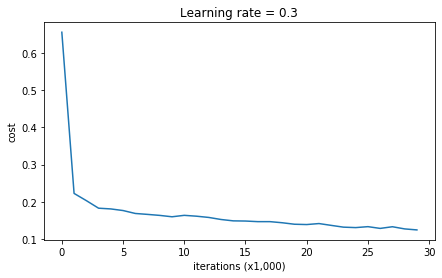

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [11]:
parameters = model(train_X, train_Y)
print('On the training set:')
predictions_train = predict(train_X, train_Y, parameters)
print('On the test set:')
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.

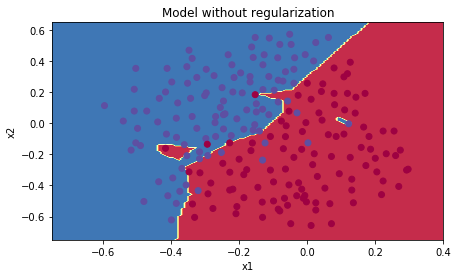

In [13]:
plt.title('Model without regularization')
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## 2 - L2 Regularization